In [115]:
# from transformers import LlamaTokenizerFast, BertTokenizerFast, AutoTokenizer
# from tqdm import tqdm
# from datasets import load_dataset

# tokenizer_llama = LlamaTokenizerFast.from_pretrained("hf-internal-testing/llama-tokenizer")
# tokenizer_bloom = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# tokenizer_Bert = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")


In [116]:
import os
import pandas as pd
import re

# Define the folder path
path = './llm_outputs/llama3_405B'

# List all .tsv files in the folder
tsv_files = [f for f in os.listdir(path) if f.endswith('.tsv')]

# Dictionary to store the DataFrame of accuracies for each file
file_subject_accuracies = {}

# Process each TSV file
for tsv_file in tsv_files:
    file_path = os.path.join(path, tsv_file)
    try:
        # Read the TSV file with error handling
        data = pd.read_csv(file_path, sep='\t', on_bad_lines='warn')
        
        # Ensure the data contains the required columns
        expected_columns = ['question', 'choices', 'answer', 'subject', 'llm']
        if not all(col in data.columns for col in expected_columns):
            print(f"Skipping {tsv_file} due to missing columns.")
            continue

        # Initialize an empty list to hold accuracy values for each record
        accuracy_records = []

        # Check if the `answer` is in the `llm` column for each row
        for _, row in data.iterrows():
            # Use regex to extract only the letter part (A, B, C, etc.) from the llm column
            llm_answers = [match.group(1) for match in re.finditer(r'([A-Za-z])\)', str(row['llm']))]

            # Check if the answer exists in the llm choices (only comparing the letter part)
            is_correct = 1 if row['answer'].strip() in llm_answers else 0
            accuracy_records.append(is_correct)
        
        # Add the accuracy as a new column to the DataFrame
        data['accuracy'] = accuracy_records

        # Store the updated DataFrame in the dictionary
        file_subject_accuracies[tsv_file] = data

        # Save the DataFrame with accuracy to a CSV file named after the language (file name without extension)
        language_name = os.path.splitext(tsv_file)[0]  # Remove '.tsv' extension
        save_path = os.path.join(path, f"{language_name}_accuracy.csv")
        data.to_csv(save_path, index=False)
    
    except Exception as e:
        print(f"Error processing {tsv_file}: {e}")


In [117]:
import os

# Define the folder path where files are saved
path = './llm_outputs/llama3_405B'

# List all files ending with "_accuracy.csv"
created_files = [f for f in os.listdir(path) if f.endswith('_accuracy.csv')]

# Print the list of created files
print("List of accuracy files created:")
for file in created_files:
    print(file)


List of accuracy files created:
amh_accuracy.csv
twi_accuracy.csv
hau_accuracy.csv
xho_accuracy.csv
zul_accuracy.csv
lin_accuracy.csv
sna_accuracy.csv
kin_accuracy.csv
ewe_accuracy.csv
orm_accuracy.csv
lug_accuracy.csv
yor_accuracy.csv
wol_accuracy.csv
ibo_accuracy.csv
swa_accuracy.csv
eng_accuracy.csv
fra_accuracy.csv
sot_accuracy.csv


In [118]:
# List all the accuracy CSV files
accuracy_files = [f for f in os.listdir(path) if f.endswith('_accuracy.csv')]

# Initialize a list to hold individual DataFrames
dfs = []

# Loop through each CSV file and load it into a DataFrame
for accuracy_file in accuracy_files:
    file_path = os.path.join(path, accuracy_file)
    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add a column to the DataFrame for the file name (language)
        df['language'] = accuracy_file.replace('_accuracy.csv', '')  # Remove '_accuracy.csv' to get the language name
        
        # Add the DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {accuracy_file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True).drop(columns=["Unnamed: 0"])

# Display the resulting DataFrame
(combined_df)


,question,choices,answer,subject,llm,accuracy,language
0,በ 24 = 2p ውስጥ የ p ዋጋ ስንት ነው,"['p = 5', 'p = 9', 'p = 13', 'p = 25']",C,elementary_mathematics,በ 24 = 2p \n\nበ 24 = 2 * 12 \n\nበ 24 / 2 = 12 ...,0,amh
1,ወይዘሮ ፔሬዝ በ5 ቀናት ውስጥ በአጠቃላይ 40 ማይል ነድታለች። በየቀኑ ...,"['5', '7', '8', '9']",C,elementary_mathematics,C) 8,1,amh
2,የ −40 ÷ (−8) ድርሻ ፈልጉ,"['1 ሲካፈል 5', '-5', '−1 ሲካፈል 5', '5']",D,elementary_mathematics,D) 5,1,amh
3,የእግር ኳስ ቡድን የእግር ኳስ ኳሶችን ለመግዛት $90.00 አለው። አንድ...,"['4', '5', '6', '7']",B,elementary_mathematics,B) 5,1,amh
4,አንተ እና ሶስት ጓደኞች ወደ ኮንሰርት ሄዳችሁ። የአራት ትኬቶች አጠቃላይ...,"['4t = 112; $449', '4t = 112; $29', 't over 4 ...",B,elementary_mathematics,B) 4t = 112; $28,1,amh
...,...,...,...,...,...,...,...
8995,Ho fokotswa ha meputso e fokolang tlhahisong y...,['sehlahiswa se tlwaelehileng sa mosebetsi se ...,D,high_school_microeconomics,B) Kakaretso ya ho etsa sehlahiswa e qala ho wa,0,sot
8996,Seo o se telang ho tswellisa tsela e nngwe e b...,"['tjhelete.', 'lefatshe', 'ditjeho tsa tjhelet...",D,high_school_microeconomics,D) ditjeho tsa monyetla,1,sot
8997,Ke efe ho tse latelang e senang tshobotsi ya i...,"['Ho kena mahala indastering.', 'Product diffe...",B,high_school_microeconomics,D) dihlahiswa tse tshwanang,0,sot
8998,E amana le mmaraka wa basebetsi o nang le more...,"['e lefa hanyane mme e hira haholo', 'e lefa h...",D,high_school_microeconomics,A) e lefa hanyane mme e hira haholo,0,sot


These fertility scores have been generated using the LLama Tokenizer.

In [119]:
results = {'amh': {'elementary_mathematics': 8.169310071371926,
  'high_school_geography': 12.471759447379114,
  'international_law': 12.754734670916932,
  'global_facts': 10.34185680566483,
  'high_school_microeconomics': 12.194616977225673},
 'eng': {'global_facts': 1.7413005272407733,
  'international_law': 1.3104704097116844,
  'high_school_microeconomics': 1.355036855036855,
  'high_school_geography': 1.4076950229438758,
  'elementary_mathematics': 1.8476953907815632},
 'ewe': {'elementary_mathematics': 2.7390155269243475,
  'high_school_geography': 3.0760442699036057,
  'international_law': 3.1113895501816815,
  'global_facts': 2.867622259696459,
  'high_school_microeconomics': 2.913830783640337},
 'fra': {'elementary_mathematics': 2.0478247454489353,
  'high_school_geography': 1.8347250215951627,
  'international_law': 1.7691109669046075,
  'global_facts': 1.9579439252336448,
  'high_school_microeconomics': 1.7249738402511336},
 'hau': {'elementary_mathematics': 2.598220171390903,
  'high_school_geography': 2.57459556620731,
  'international_law': 2.625166622234071,
  'global_facts': 2.560741885625966,
  'high_school_microeconomics': 2.398886827458256},
 'ibo': {'elementary_mathematics': 3.049191374663073,
  'high_school_geography': 2.91033386327504,
  'international_law': 2.893111984855104,
  'global_facts': 2.9321065989847717,
  'high_school_microeconomics': 3.062881449972258},
 'kin': {'elementary_mathematics': 2.9844176081028437,
  'high_school_geography': 3.1577330146807783,
  'international_law': 3.382427200807945,
  'global_facts': 3.074212131480854,
  'high_school_microeconomics': 3.300406871609403},
 'lin': {'elementary_mathematics': 2.244910742248669,
  'high_school_geography': 1.958265139116203,
  'international_law': 1.9987187700192184,
  'global_facts': 2.2060910703725605,
  'high_school_microeconomics': 1.9851812176397072},
 'lug': {'elementary_mathematics': 3.12407472682411,
  'high_school_geography': 3.6039837947332884,
  'international_law': 3.6110162916989914,
  'global_facts': 3.3181212524983343,
  'high_school_microeconomics': 3.6844167408726625},
 'orm': {'elementary_mathematics': 3.1656671664167915,
  'high_school_geography': 3.4827109266943292,
  'international_law': 3.4087059620596207,
  'global_facts': 3.4841002618780395,
  'high_school_microeconomics': 3.347603121516165},
 'sna': {'elementary_mathematics': 3.0805258833196385,
  'high_school_geography': 3.3734439834024896,
  'international_law': 3.43456408273729,
  'global_facts': 3.5474513054289267,
  'high_school_microeconomics': 3.5469218353700716},
 'sot': {'elementary_mathematics': 2.3866427073974243,
  'high_school_geography': 2.1321905868681,
  'international_law': 2.1777719596805865,
  'global_facts': 2.3518518518518516,
  'high_school_microeconomics': 2.279891304347826},
 'swa': {'elementary_mathematics': 2.6056666666666666,
  'global_facts': 2.75,
  'high_school_geography': 2.556863960334676,
  'high_school_microeconomics': 2.5223320158102767,
  'international_law': 2.5636687444345503},
 'twi': {'elementary_mathematics': 2.7055311125078565,
  'high_school_geography': 2.7431264728986644,
  'international_law': 2.4974339717111027,
  'global_facts': 2.5944263267121257,
  'high_school_microeconomics': 2.36592},
 'wol': {'elementary_mathematics': 2.3369693396226414,
  'high_school_geography': 2.2710027100271004,
  'international_law': 2.2971537807986406,
  'global_facts': 2.3599489795918367,
  'high_school_microeconomics': 2.230886006072316},
 'xho': {'elementary_mathematics': 3.6374164810690424,
  'high_school_geography': 4.023513139695712,
  'international_law': 4.131764705882353,
  'global_facts': 4.206046511627907,
  'high_school_microeconomics': 3.8396094839609485},
 'yor': {'elementary_mathematics': 3.384788913954238,
  'high_school_geography': 4.049926144756277,
  'international_law': 3.613971084988515,
  'global_facts': 3.8452344468280724,
  'high_school_microeconomics': 3.451475353914378},
 'zul': {'elementary_mathematics': 3.28125,
  'high_school_geography': 3.9418282548476453,
  'international_law': 4.0216966804078975,
  'global_facts': 3.953853046594982,
  'high_school_microeconomics': 4.002333722287048}}

In [120]:
def map_fertility(row):
    language = row['language']
    subject = row['subject']
    return results.get(language, {}).get(subject, None)  # Default to None if not found

# Apply the function to the DataFrame to create a new column 'fertility'
combined_df['fertility'] = combined_df.apply(map_fertility, axis=1)

# Display the updated DataFrame
combined_df.to_csv('llama_per_subject_results.csv', index=False)


In [121]:
aggregated_df = combined_df.groupby(['language', 'subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

,language,subject,mean_accuracy,mean_fertility
0,amh,elementary_mathematics,0.73,8.169310
1,amh,global_facts,0.53,10.341857
2,amh,high_school_geography,0.61,12.471759
3,amh,high_school_microeconomics,0.53,12.194617
4,amh,international_law,0.74,12.754735
...,...,...,...,...
85,zul,elementary_mathematics,0.68,3.281250
86,zul,global_facts,0.48,3.953853
87,zul,high_school_geography,0.53,3.941828
88,zul,high_school_microeconomics,0.37,4.002334


In [122]:
# Calculate the correlation between mean_accuracy and mean_fertility
correlation = aggregated_df.groupby('language').apply(lambda x: x['mean_accuracy'].corr(x['mean_fertility'])).reset_index(name='corr')

# Display the correlation
print(f"Correlation between mean_accuracy and mean_fertility: {correlation}")


Correlation between mean_accuracy and mean_fertility:    language      corr
0       amh -0.214951
1       eng -0.732275
2       ewe -0.505043
3       fra -0.615812
4       hau  0.638102
5       ibo -0.134323
6       kin -0.120172
7       lin  0.551819
8       lug -0.655435
9       orm -0.746822
10      sna -0.790350
11      sot  0.243218
12      swa -0.474497
13      twi  0.307688
14      wol  0.612445
15      xho -0.388359
16      yor -0.265962
17      zul -0.754240


/var/folders/cn/1py0zvm95nx9kp_1_zqwycrm0000gn/T/ipykernel_28848/3158454731.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation = aggregated_df.groupby('language').apply(lambda x: x['mean_accuracy'].corr(x['mean_fertility'])).reset_index(name='corr')


In [123]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_fertility'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


     correlation   p_value
amh    -0.214951  0.728438
eng    -0.732275  0.159444
ewe    -0.505043  0.385450
fra    -0.615812  0.268772
hau     0.638102  0.246664
ibo    -0.134323  0.829491
kin    -0.120172  0.847362
lin     0.551819  0.334897
lug    -0.655435  0.229832
orm    -0.746822  0.146977
sna    -0.790350  0.111538
sot     0.243218  0.693406
swa    -0.474497  0.419357
twi     0.307688  0.614512
wol     0.612445  0.272155
xho    -0.388359  0.518253
yor    -0.265962  0.665402
zul    -0.754240  0.140736


<Figure size 1200x800 with 0 Axes>

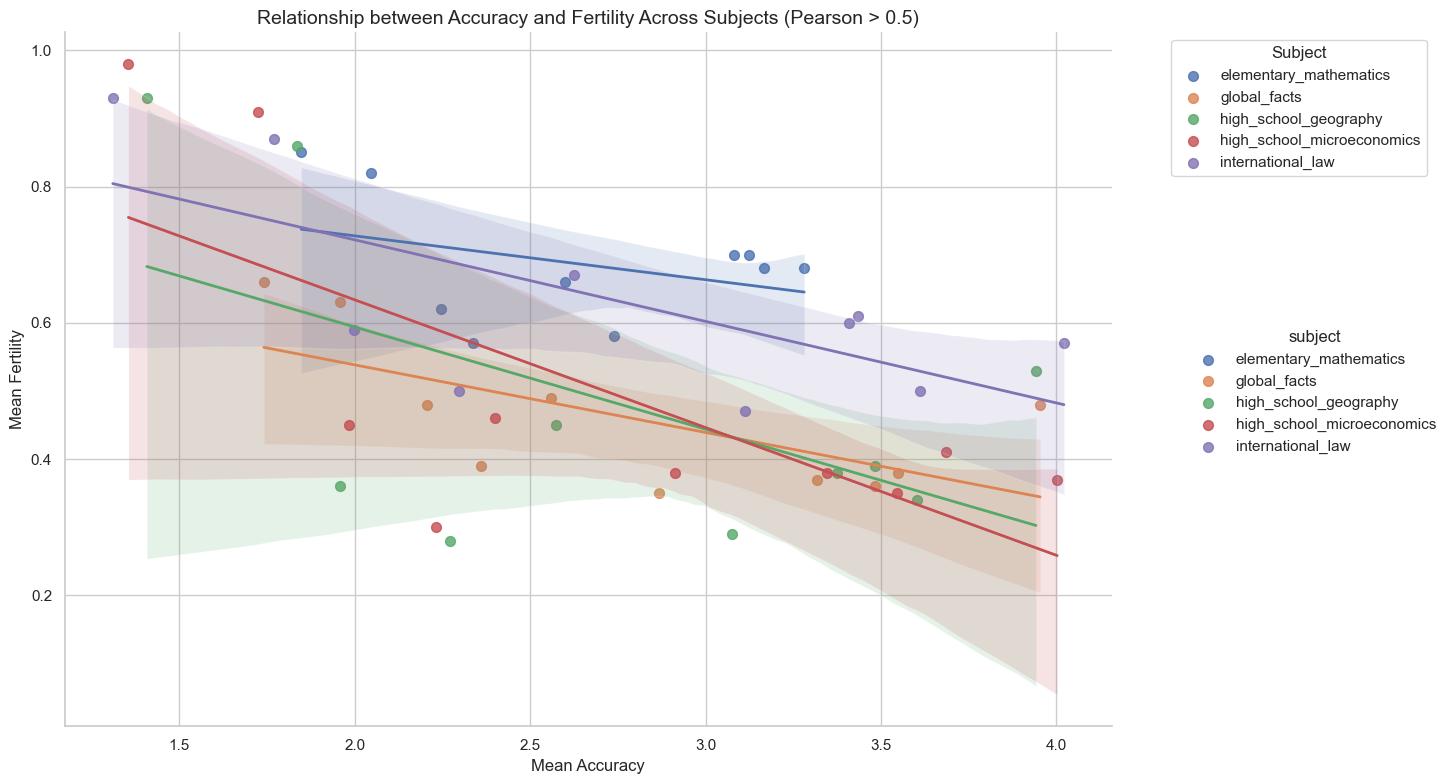

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.5].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df[aggregated_df['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_fertility",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
)

# Customize the plot
plt.title("Relationship between Accuracy and Fertility Across Subjects (Pearson > 0.5)", fontsize=14)
plt.xlabel("Mean Accuracy", fontsize=12)
plt.ylabel("Mean Fertility", fontsize=12)

# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show the plot
plt.show()
